In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/climate-change-earth-surface-temperature-data/GlobalTemperatures.csv
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByState.csv
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCountry.csv
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCity.csv
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByMajorCity.csv


In [2]:
plt.style.use('classic') # the classic style works better for the first part, later we'll change it

# In this notebook I work with the city datasets attempting to visualize any possible long term trend of the temperature values.




# 1. Major Cities
**First we're going to work with the dataset of the Major Cities**

In [3]:
major_cities = pd.read_csv('../input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByMajorCity.csv')

In [4]:
major_cities.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [5]:
major_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239177 entries, 0 to 239176
Data columns (total 7 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             239177 non-null  object 
 1   AverageTemperature             228175 non-null  float64
 2   AverageTemperatureUncertainty  228175 non-null  float64
 3   City                           239177 non-null  object 
 4   Country                        239177 non-null  object 
 5   Latitude                       239177 non-null  object 
 6   Longitude                      239177 non-null  object 
dtypes: float64(2), object(5)
memory usage: 12.8+ MB


In [6]:
major_cities.nunique() # Chcking the number of unique values per column. 

dt                                3239
AverageTemperature               56348
AverageTemperatureUncertainty     6269
City                               100
Country                             49
Latitude                            49
Longitude                           93
dtype: int64

Looks like we have 3239 unique date entries for 100 cities from 49 countries.

But how many are missing?

In [7]:
major_cities.isnull().sum()/len(major_cities)

dt                               0.000000
AverageTemperature               0.045999
AverageTemperatureUncertainty    0.045999
City                             0.000000
Country                          0.000000
Latitude                         0.000000
Longitude                        0.000000
dtype: float64

About 4.5% of each Temperature column are missing values.

Let's see to which years and cities they correspond.

In [8]:
# First, it would be really helpful to convert the 'dt' values into datetime objects
major_cities['dt'] = [datetime.strptime(date, '%Y-%m-%d') for date in major_cities['dt']]

In [9]:
nas_per_dt = major_cities.set_index('dt')['AverageTemperature'].isnull().reset_index().groupby('dt').sum()
nas_per_dt.columns = ['Missing values']

# First I set the 'dt' column as index and select only the 'AverageTemperature' column.
# Then I check for each entry if it is na, but remember that there are multiple entries with the same date.
# For this reason I need to group by each unique 'dt' value. To do this I make 'dt' a column again by reseting the index.
# Finally we group by the newly reestablished 'dt' column and sum the values which are booleans.

nas_per_dt.head(10)

,Missing values
dt,
1743-11-01,0
1743-12-01,13
1744-01-01,13
1744-02-01,13
1744-03-01,13
1744-04-01,0
1744-05-01,0
1744-06-01,0
1744-07-01,0


**Now let's plot this to get a sense of which dates have the most missing values.**

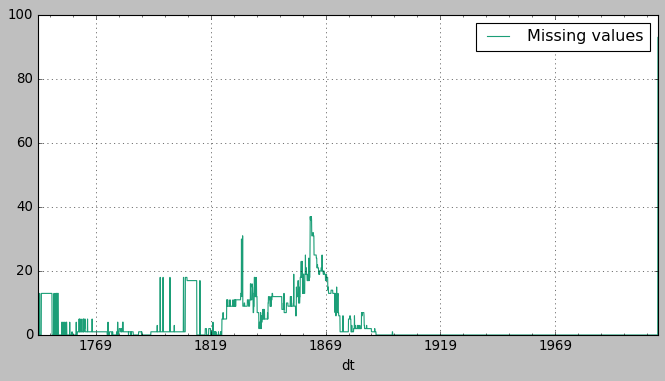

In [10]:
nas_per_dt.plot(figsize=(10,5), colormap='Dark2', grid=True)
plt.show()

 *It seems that most of the missing values are for dates in the 19th century, while the last entry which is 09-2013 has very few non-missing values.*
 
 Now let's see which cities have the most missing values

In [11]:
nas_per_city = major_cities.groupby(['dt', 'City']).mean()['AverageTemperature'].unstack(level=1).isnull().sum().sort_values()/major_cities['dt'].nunique()

# This time we need to get total missing values for each city regardless of the date.
# First I groupby the 'dt' and 'City' columns and aggregate the values with ".mean()". 
# Keep in mind that each city has only one entry per each unique date so our aggregate function basically just "aggregates" one value. 
# I could have used ".sum()" or ".max()" and get the same result.
# After grouping the values I get a Multiindex DataFrame and select only the 'AverageTemperature' column.
# Then I use the ".unstack()" method to convert the index of level 1 (which is the cities) to columns.
# Finally I use ".isnull()" and ".sum()" to get the total missing values per column (city) and I sort the values.
# I divide by the number of unique 'dt' values to get the percentage

nas_per_city.head(10)

City
Madrid              0.022538
Kiev                0.022538
Moscow              0.022538
London              0.022538
Paris               0.022538
Istanbul            0.022538
Berlin              0.022538
Saint Petersburg    0.022538
Rome                0.022538
Toronto             0.030256
dtype: float64

**Plotting the missing values per city.**

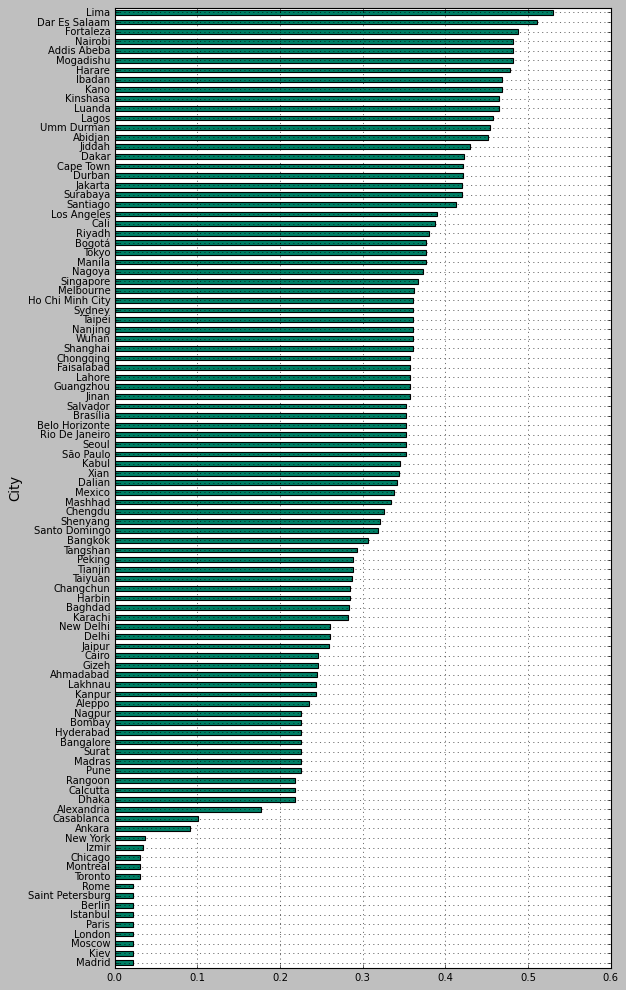

In [12]:
plt.style.use('classic') # the classic style works better for the next few plots

nas_per_city.plot(
    kind='barh',
    figsize=(8,15),
    fontsize=9,
    colormap='summer',
    grid=True)

plt.show()

*Looks like about hallf of the cities have at least 35% missing values*

For the 'AverageTemperatureUncertainty' column it would make sense that the missing values are in the same entries as the 'AverageTemperature' column. We can easily confirm it.

In [13]:
sum(major_cities['AverageTemperature'].isnull() != major_cities['AverageTemperatureUncertainty'].isnull())

0

**Next I create a time-series of the 'AverageTemperature' column for each city**

In [14]:
ts_by_city = major_cities.groupby(['dt', 'City']).mean()['AverageTemperature'].unstack(level=1)
# I use the same steps as above, except this time I stop before checking for missing values.

ts_by_city.head(10)

City,Abidjan,Addis Abeba,Ahmadabad,Aleppo,Alexandria,Ankara,Baghdad,Bangalore,Bangkok,Belo Horizonte,...,São Paulo,Taipei,Taiyuan,Tangshan,Tianjin,Tokyo,Toronto,Umm Durman,Wuhan,Xian
dt,,,,,,,,,,,,,,,,,,,,,
1743-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.106,NaN,NaN,NaN
1743-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1744-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1744-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1744-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1744-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.892,NaN,NaN,NaN
1744-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.050,NaN,NaN,NaN
1744-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,17.857,NaN,NaN,NaN
1744-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,19.130,NaN,NaN,NaN


**Now let's take the columns for the 10 cities with the least missing values and plot them**

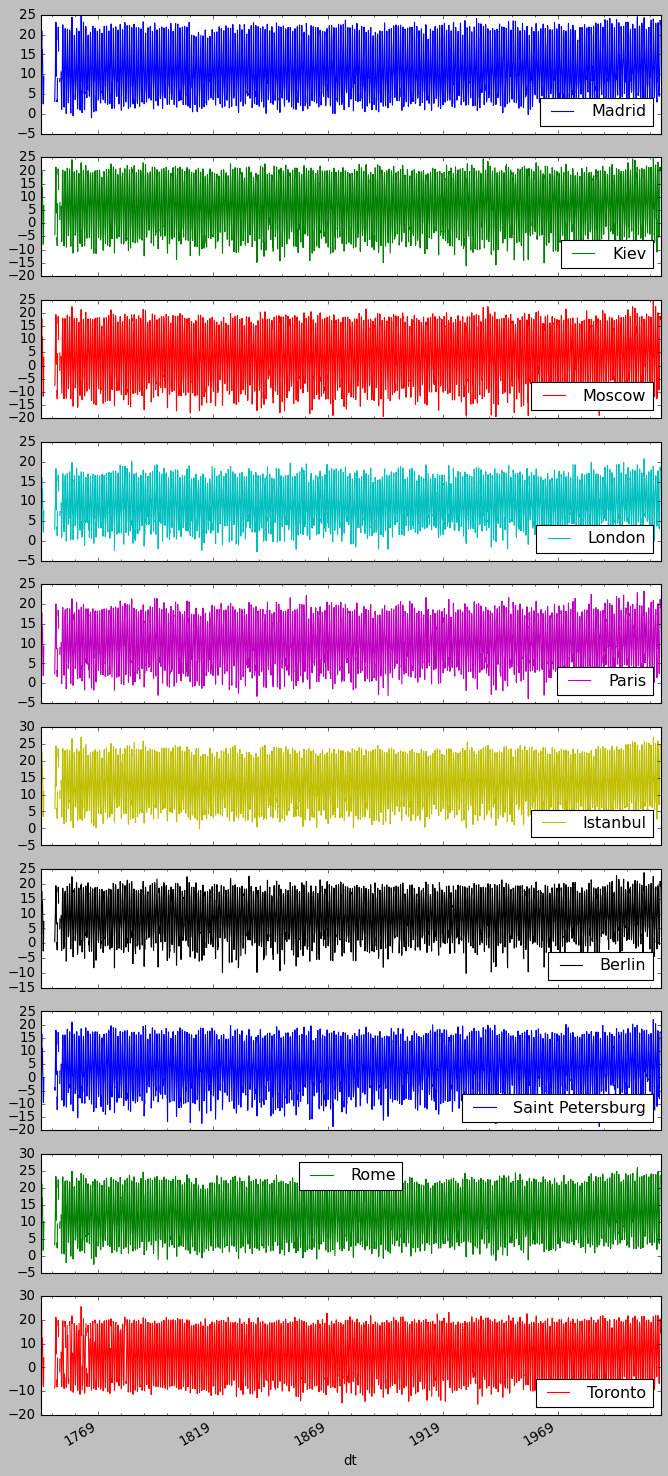

In [15]:
ten_cities = nas_per_city[:10].index.tolist()

ts_by_city[ten_cities].plot(figsize=(10,25), subplots=True)
plt.show()

**It's hard to discern any longterm trends.**
* It would be better to plot the average values per decade or even 25-year period.
* Another option would be to aggregate the temperatures by season or month in order to remove the yearly seasonality.

**Creating columns for longer periods and seasons.**

In [16]:
major_cities['month'] = major_cities['dt'].apply(lambda x: x.month)
major_cities['year'] = major_cities['dt'].apply(lambda x: x.year)
major_cities['season'] = (major_cities['month']%12+3)//3
major_cities['decade'] = major_cities['dt'].apply(lambda x: x.year//10)
major_cities['quadrant_century'] = major_cities['dt'].apply(lambda x: x.year//25)

In [17]:
major_cities.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,month,year,season,decade,quadrant_century
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W,1,1849,1,184,73
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W,2,1849,1,184,73
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W,3,1849,2,184,73
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W,4,1849,2,184,73
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W,5,1849,2,184,73


In [18]:
major_cities['quadrant_century'].unique()

array([73, 74, 75, 76, 77, 78, 79, 80, 71, 72, 70, 69])

In [19]:
# Fixing the quadrant_century values in order to know to which period they refer to

d_25_year = dict(zip(range(70,80), [str(i) + '-' + str(i+25) for i in range(1750, 2000, 25)]))
d_25_year[69] = '1743-1750'
d_25_year[80] = '2000-2013'

d_25_year

{70: '1750-1775',
 71: '1775-1800',
 72: '1800-1825',
 73: '1825-1850',
 74: '1850-1875',
 75: '1875-1900',
 76: '1900-1925',
 77: '1925-1950',
 78: '1950-1975',
 79: '1975-2000',
 69: '1743-1750',
 80: '2000-2013'}

In [20]:
major_cities['quadrant_century'] = major_cities['quadrant_century'].map(d_25_year)

In [21]:
major_cities.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,month,year,season,decade,quadrant_century
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W,1,1849,1,184,1825-1850
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W,2,1849,1,184,1825-1850
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W,3,1849,2,184,1825-1850
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W,4,1849,2,184,1825-1850
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W,5,1849,2,184,1825-1850


**Next, I create a dataframe with average temperatures by decade.**

In [22]:
decade_by_city = major_cities.groupby(['decade', 'City']).mean()['AverageTemperature'].unstack(level=1)
decade_by_city.head()

City,Abidjan,Addis Abeba,Ahmadabad,Aleppo,Alexandria,Ankara,Baghdad,Bangalore,Bangkok,Belo Horizonte,...,São Paulo,Taipei,Taiyuan,Tangshan,Tianjin,Tokyo,Toronto,Umm Durman,Wuhan,Xian
decade,,,,,,,,,,,,,,,,,,,,,
174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.928692,NaN,NaN,NaN
175,NaN,NaN,NaN,NaN,NaN,9.979965,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.974330,NaN,NaN,NaN
176,NaN,NaN,NaN,NaN,NaN,9.280417,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.140291,NaN,NaN,NaN
177,NaN,NaN,NaN,NaN,NaN,10.663333,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.663504,NaN,NaN,NaN
178,NaN,NaN,NaN,NaN,NaN,10.286567,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.628922,NaN,NaN,NaN


**Let's plot the ten cities from before**

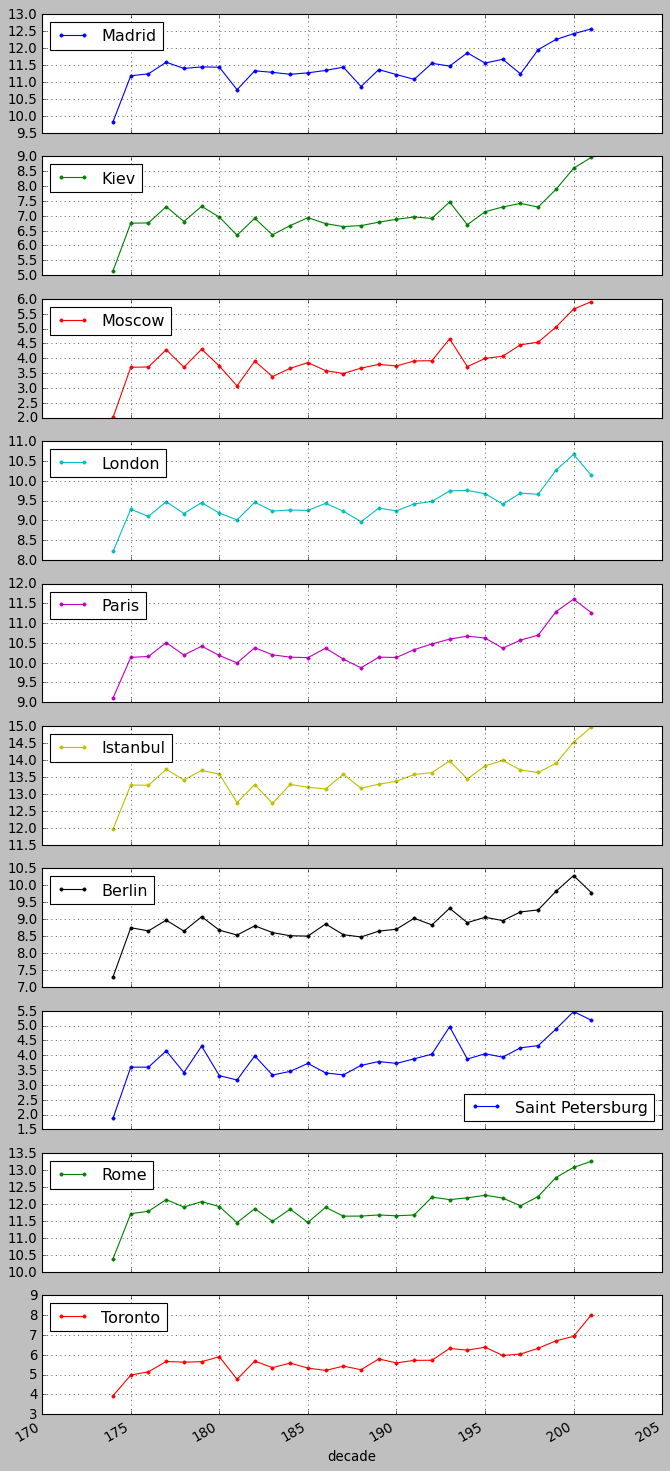

In [23]:
decade_by_city[ten_cities].plot(figsize=(10,25), subplots=True, grid=True, marker='.',)
plt.show()

**A steep increase after the 1950s stands out**

**What about other cities?**

Let's plot the cities with the highest average increase over each decade

In [24]:
top_ten_diff_decade = decade_by_city.diff().mean().sort_values()[-10:].index.tolist() 
top_ten_diff_decade

['Kiev',
 'New York',
 'Moscow',
 'Toronto',
 'Mashhad',
 'Gizeh',
 'Cairo',
 'Montreal',
 'Riyadh',
 'Baghdad']

In [25]:
# We'll swap Kiev, Moscow and Toronto with the next three since we already saw them above
top_ten_diff_decade = decade_by_city.diff().mean().sort_values()[-13:].index.tolist() 
top_ten_diff_decade = [i for i in top_ten_diff_decade if i not in ten_cities]
top_ten_diff_decade

['Jiddah',
 'Umm Durman',
 'Chicago',
 'New York',
 'Mashhad',
 'Gizeh',
 'Cairo',
 'Montreal',
 'Riyadh',
 'Baghdad']

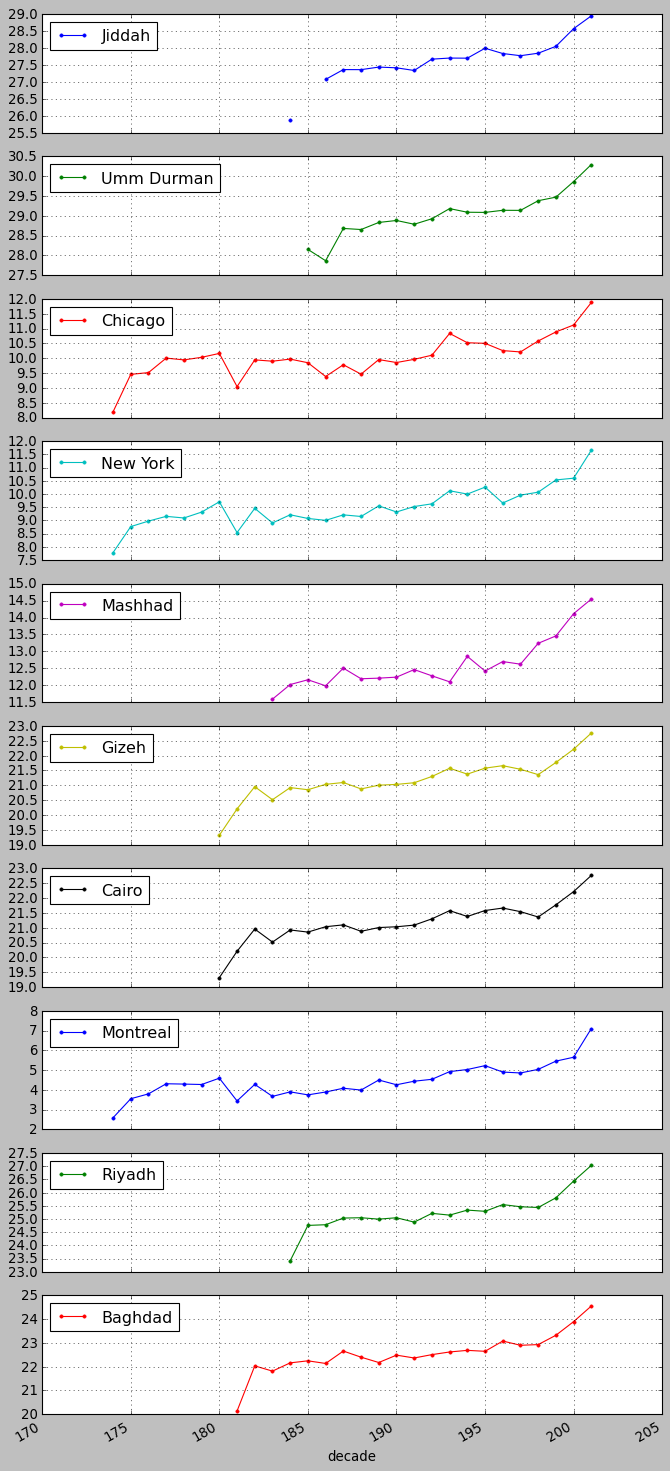

In [26]:
decade_by_city[top_ten_diff_decade].plot(figsize=(10,25), subplots=True, grid=True, marker='.',)
plt.show()

**What about cities with the smallest average increase over each decade?**

In [27]:
last_ten_diff_decade = decade_by_city.diff().mean().sort_values()[:11].index.tolist() 
last_ten_diff_decade

['Shenyang',
 'Dalian',
 'Aleppo',
 'Kabul',
 'Delhi',
 'New Delhi',
 'Bombay',
 'Dhaka',
 'Karachi',
 'Kanpur',
 'Lakhnau']

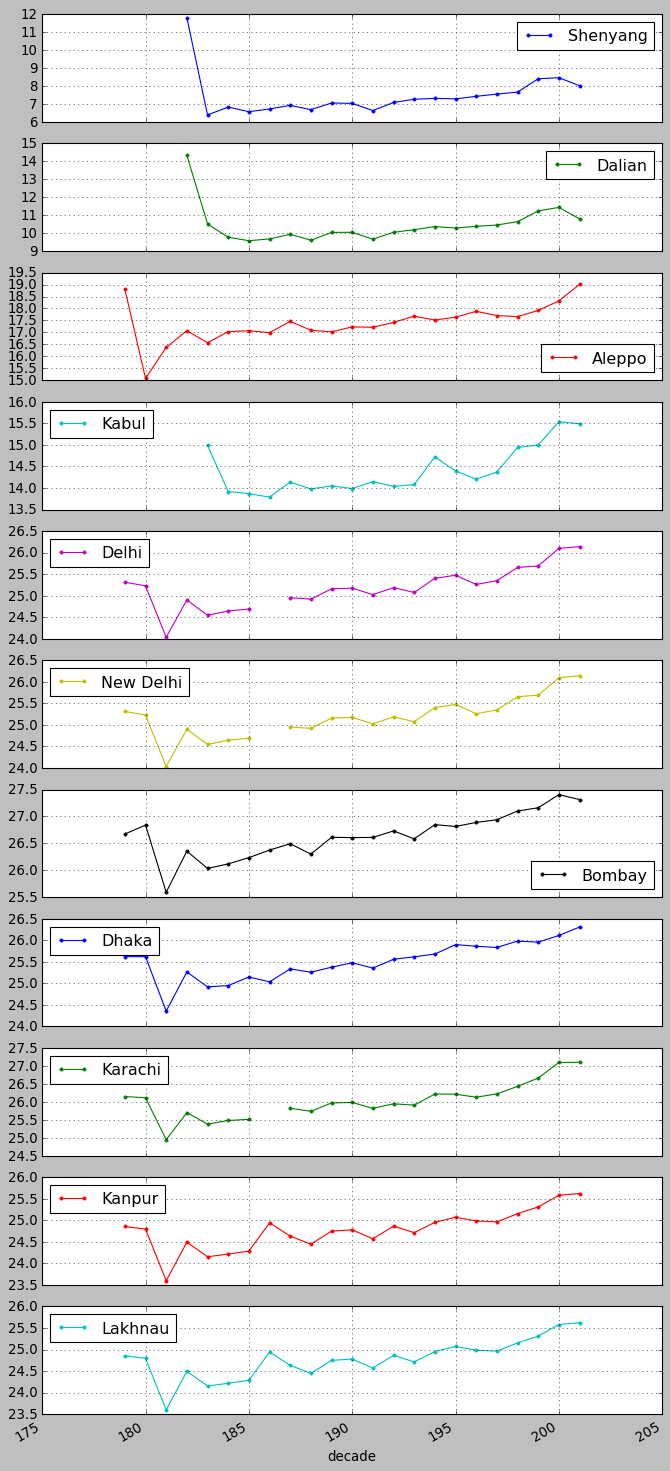

In [28]:
decade_by_city[last_ten_diff_decade].plot(figsize=(10,25), subplots=True, grid=True, marker='.',)
plt.show()

***Besides the first three, the other cities are in India and the neighboring countries. What they all have in common is a steep decline of about 1.5 degrees in the beginning of the 19th century followed immediately by an upwards spike. After that, we see an almost continuous increase of constant rate.***

***The first two cities, both in Northeastern China, not far from each other, show an identical downward spike in the middle of the 19th century, when their data begin. This could be an anomally of the data since it's difficult to imagine such a steep decline between two decades.***

Let's check a few more cities, this time close to the median average rate of increase by decade.

In [29]:
med_ten_diff_decade = decade_by_city.diff().mean().sort_values()[45:55].index.tolist() 
med_ten_diff_decade

['Cape Town',
 'Xian',
 'Tokyo',
 'Paris',
 'Taiyuan',
 'Bogotá',
 'Melbourne',
 'Chongqing',
 'Shanghai',
 'Dakar']

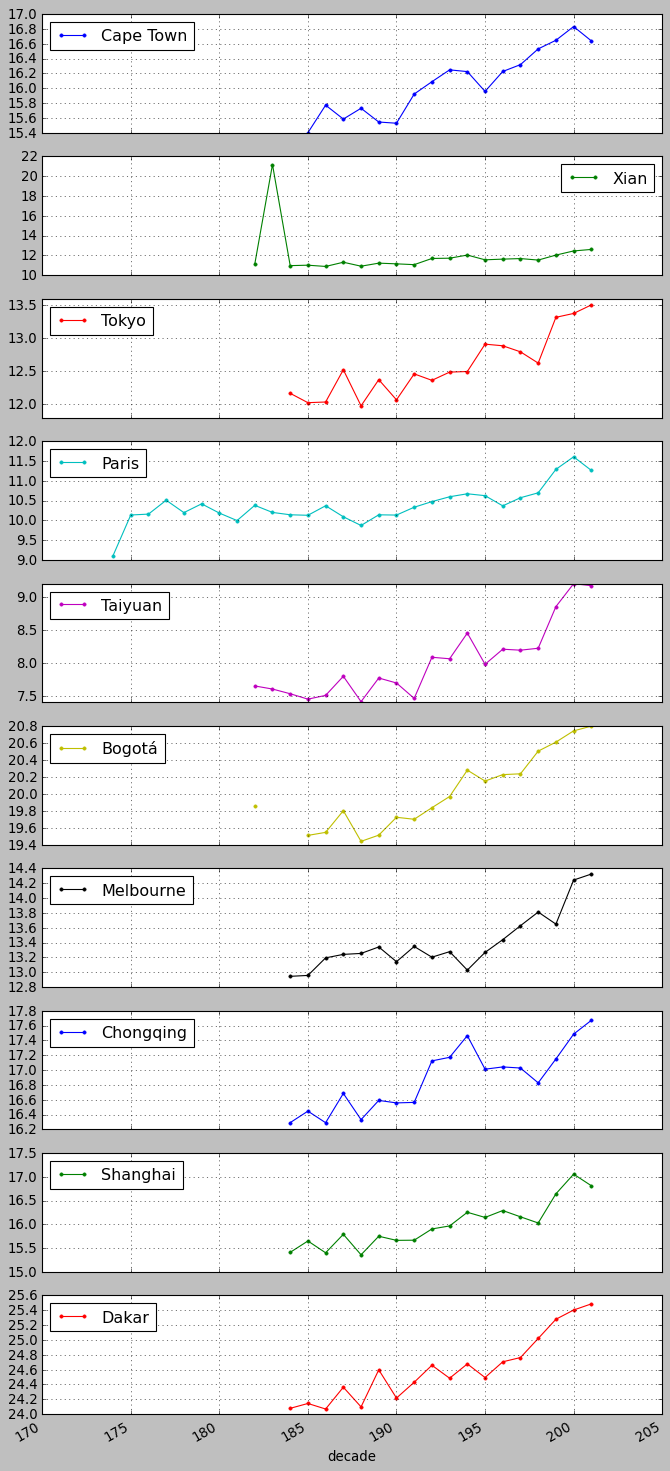

In [30]:
decade_by_city[med_ten_diff_decade].plot(figsize=(10,25), subplots=True, grid=True, marker='.',)
plt.show()

**That spike in Xian is definetly not realistic. Keep in mind that we're talking about decade averages!**

### **Next we try to further normalize the curves by plotting the averages over 25-year periods**

In [31]:
quad_century_by_city = major_cities.groupby(['quadrant_century', 'City']).mean()['AverageTemperature'].unstack(level=1)
# Better drop the first period since it's only seven years.
quad_century_by_city = quad_century_by_city.iloc[1:]

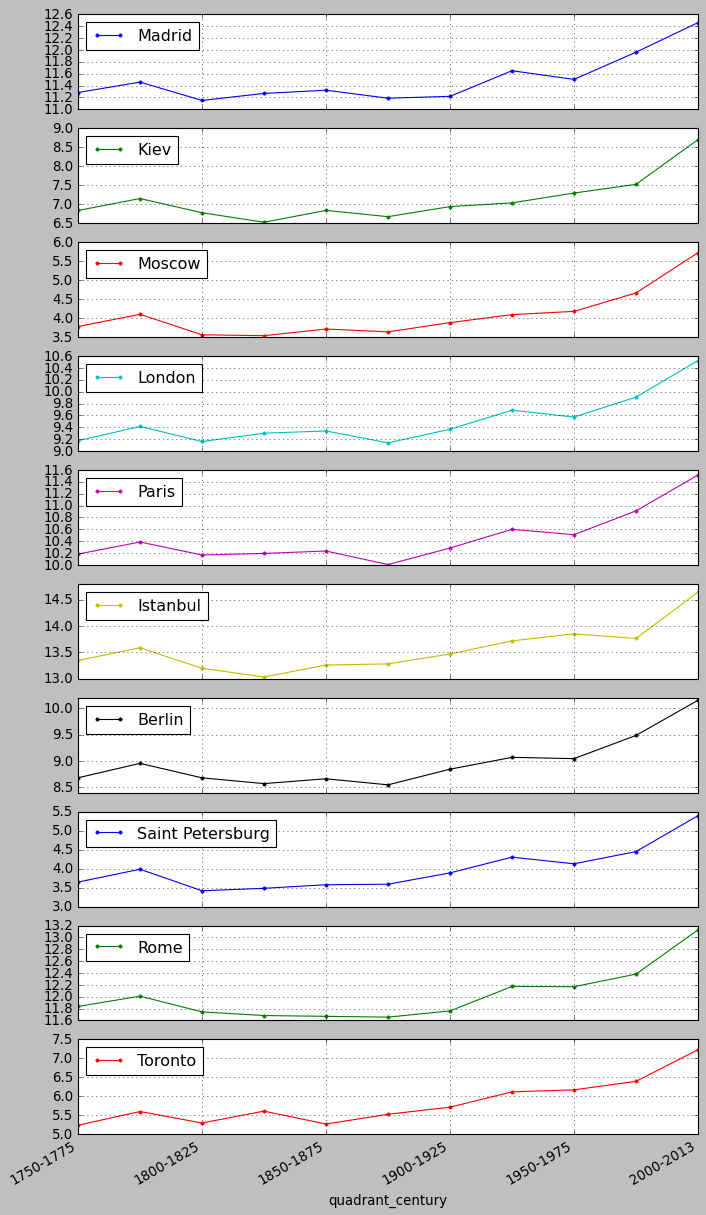

In [32]:
quad_century_by_city[ten_cities].plot(subplots=True, figsize=(10,20), grid=True, marker='.',)
plt.show()

***All curves look about flat until around the middle of the 20th century when they begin to rise.***

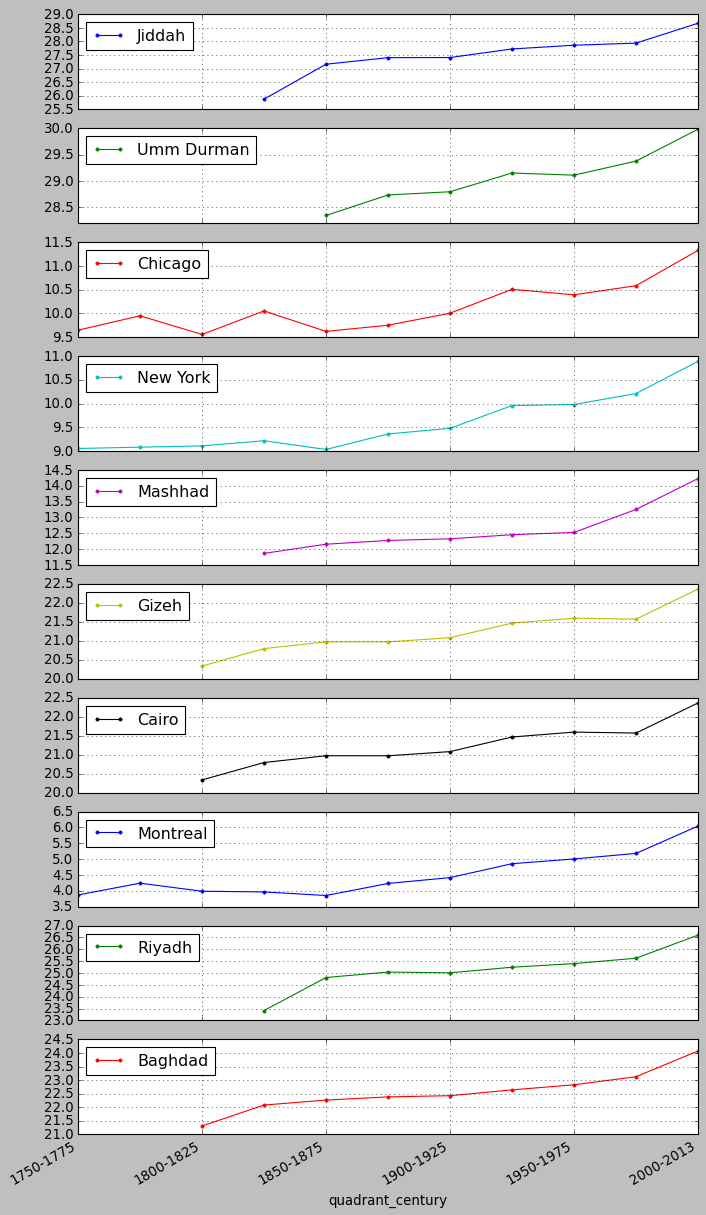

In [33]:
quad_century_by_city[top_ten_diff_decade].plot(subplots=True, figsize=(10,20), grid=True, marker='.',)
plt.show()

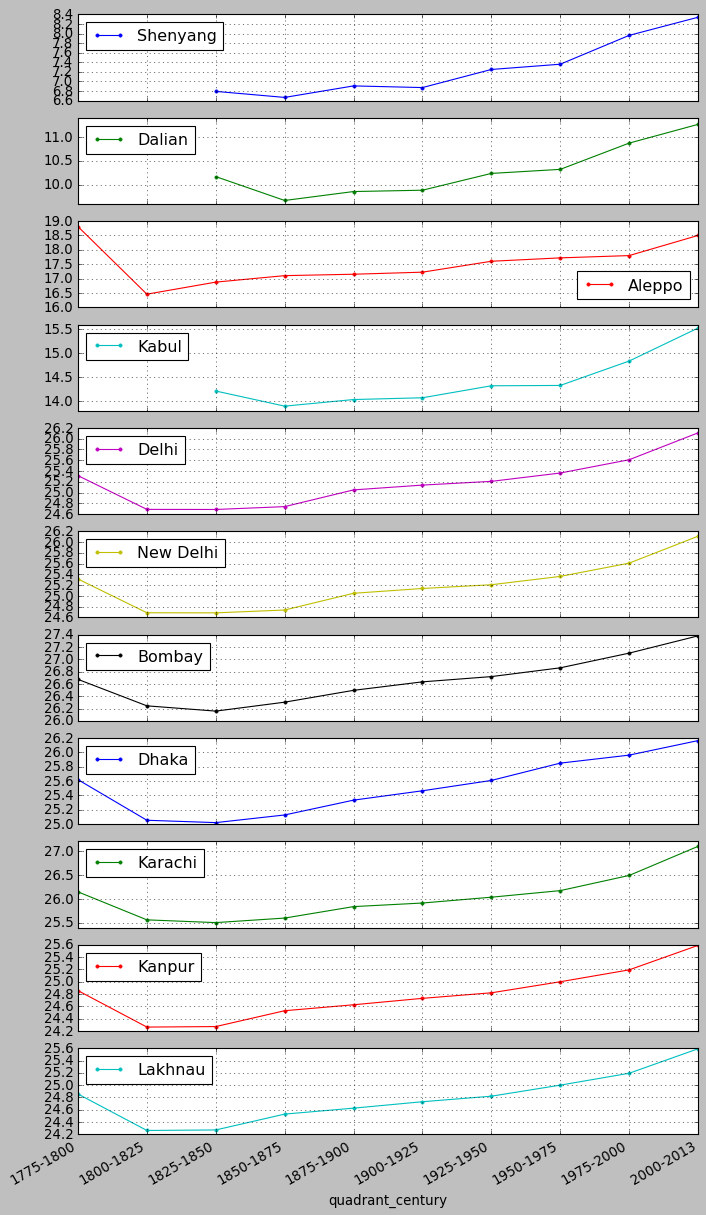

In [34]:
quad_century_by_city[last_ten_diff_decade].plot(subplots=True, figsize=(10,20), grid=True, marker='.',)
plt.show()

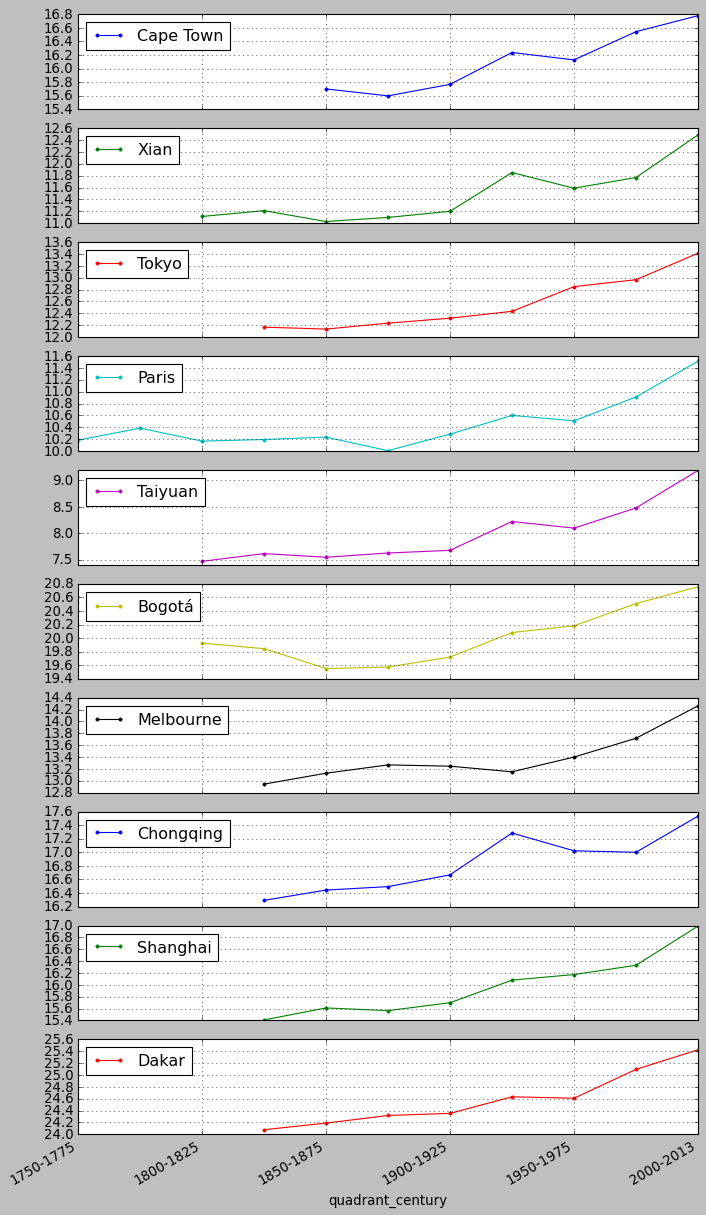

In [35]:
quad_century_by_city[med_ten_diff_decade].plot(subplots=True, figsize=(10,20), grid=True, marker='.',)
plt.show()

## All the graphs tell a similar story.
### Before moving on let's have a look at data for specific months or seasons.

In [36]:
winter_only = major_cities.groupby(['quadrant_century', 'season', 'City']).mean()['AverageTemperature'].xs(1, level=1).unstack(level=1).iloc[1:]
winter_only

City,Abidjan,Addis Abeba,Ahmadabad,Aleppo,Alexandria,Ankara,Baghdad,Bangalore,Bangkok,Belo Horizonte,...,São Paulo,Taipei,Taiyuan,Tangshan,Tianjin,Tokyo,Toronto,Umm Durman,Wuhan,Xian
quadrant_century,,,,,,,,,,,,,,,,,,,,,
1750-1775,NaN,NaN,NaN,NaN,NaN,-1.061429,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.274056,NaN,NaN,NaN
1775-1800,NaN,NaN,20.130200,6.726500,14.784320,-0.070907,NaN,22.867300,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.224851,NaN,NaN,NaN
1800-1825,NaN,NaN,20.102367,5.718245,14.148600,-0.309440,10.777000,22.837283,24.509600,NaN,...,NaN,NaN,-6.669462,-2.329538,-3.174231,NaN,-7.578560,NaN,NaN,-1.174667
1825-1850,26.529333,NaN,20.281459,6.000560,14.314400,-0.577267,10.308493,23.011230,24.989617,22.413417,...,22.078444,16.921444,-6.834083,-2.464529,-3.316708,2.194667,-6.661307,NaN,5.130000,-1.039833
1850-1875,26.258172,16.863000,20.133490,6.134027,14.344027,-0.303507,10.240720,22.872750,24.742986,22.346625,...,22.000819,16.715080,-7.141933,-2.824373,-3.735947,1.570479,-7.308947,22.981393,4.859200,-1.381040
1875-1900,26.219250,16.803652,20.374093,5.907800,14.175000,-0.679373,10.296707,22.915653,24.776827,22.518760,...,22.267747,16.551147,-7.299800,-2.980893,-3.826520,1.793907,-7.194427,23.237787,4.645800,-1.559227
1900-1925,26.799000,17.028693,20.401920,6.357347,14.594507,0.049787,10.342173,23.186347,24.986987,22.527573,...,22.167453,16.940907,-7.000467,-2.642213,-3.501653,2.005120,-7.566547,23.542360,5.124053,-1.298000
1925-1950,27.198413,17.538893,20.449227,6.673640,14.948893,0.131227,10.676413,23.325307,25.483693,22.851840,...,22.469800,17.192107,-6.716240,-2.457133,-3.441453,1.917960,-6.642293,24.078080,5.315760,-0.769507
1950-1975,27.088587,17.258587,20.675867,6.873293,15.066067,0.616893,10.992600,23.418067,25.527640,23.013400,...,22.634467,17.308813,-6.712680,-2.357813,-3.152307,2.729147,-6.623173,23.710653,5.268400,-1.008853


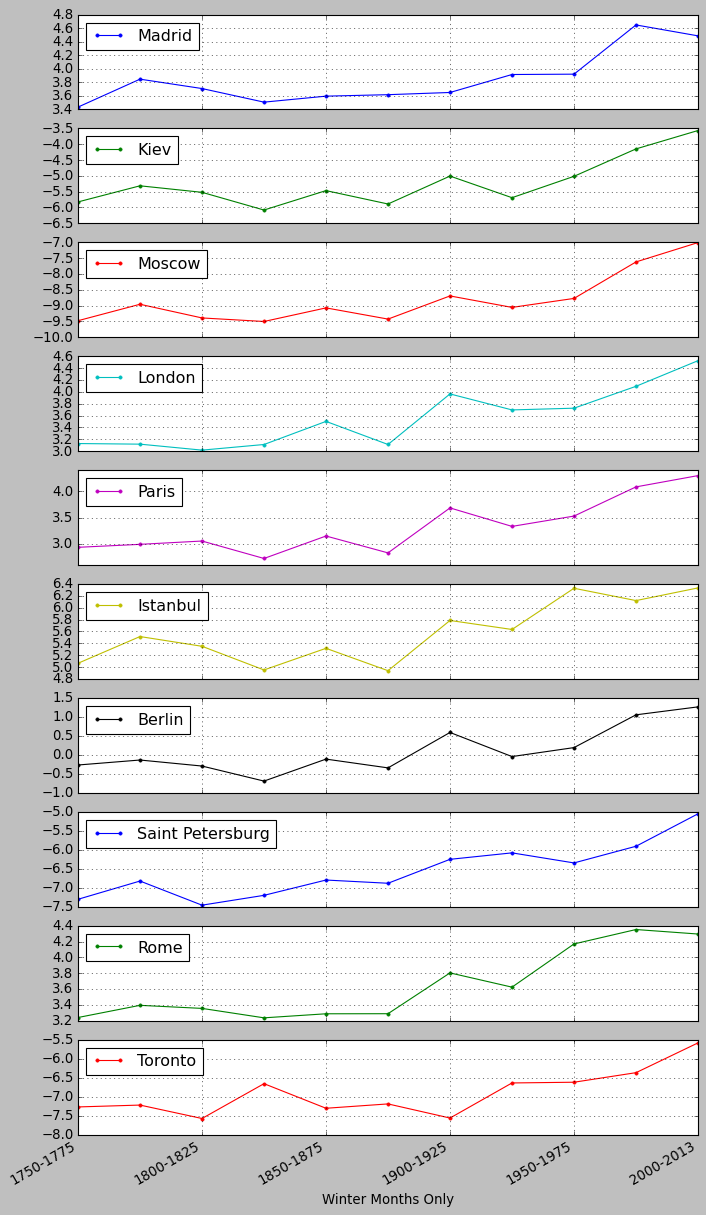

In [37]:
winter_only[ten_cities].plot(subplots=True, figsize=(10,20), grid=True, xlabel='Winter Months Only', marker='.')
plt.show()

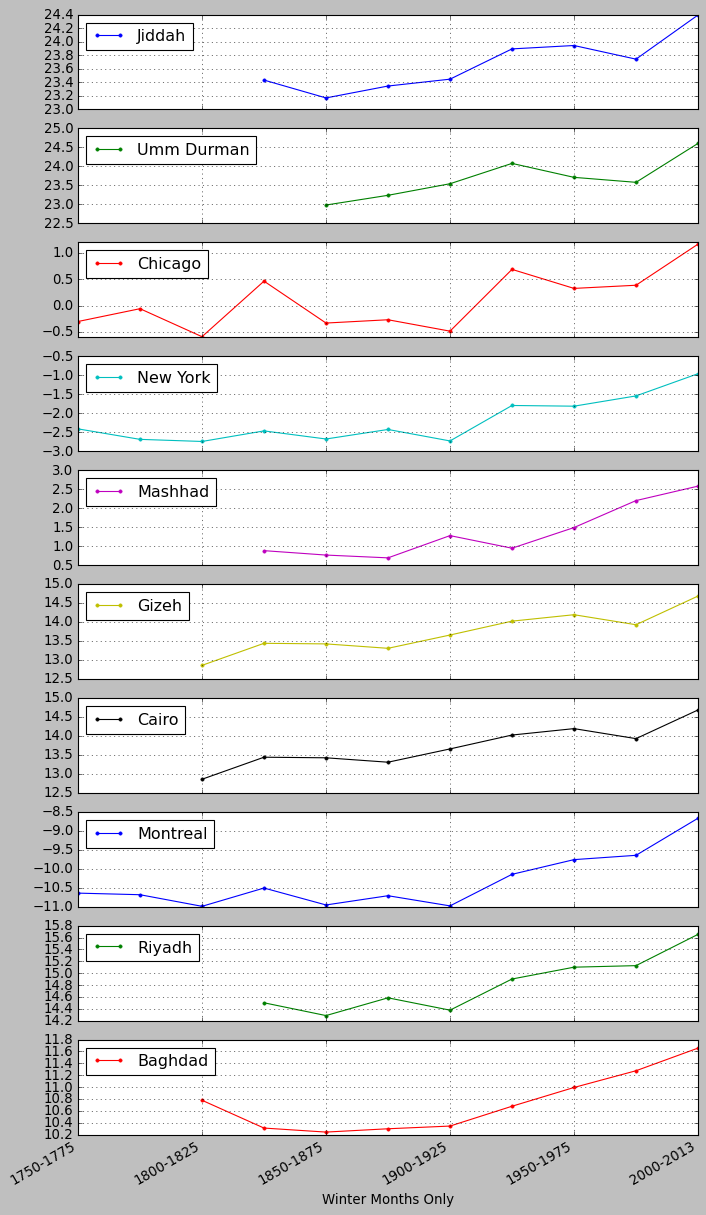

In [38]:
winter_only[top_ten_diff_decade].plot(subplots=True, figsize=(10,20), grid=True, xlabel='Winter Months Only', marker='.')
plt.show()

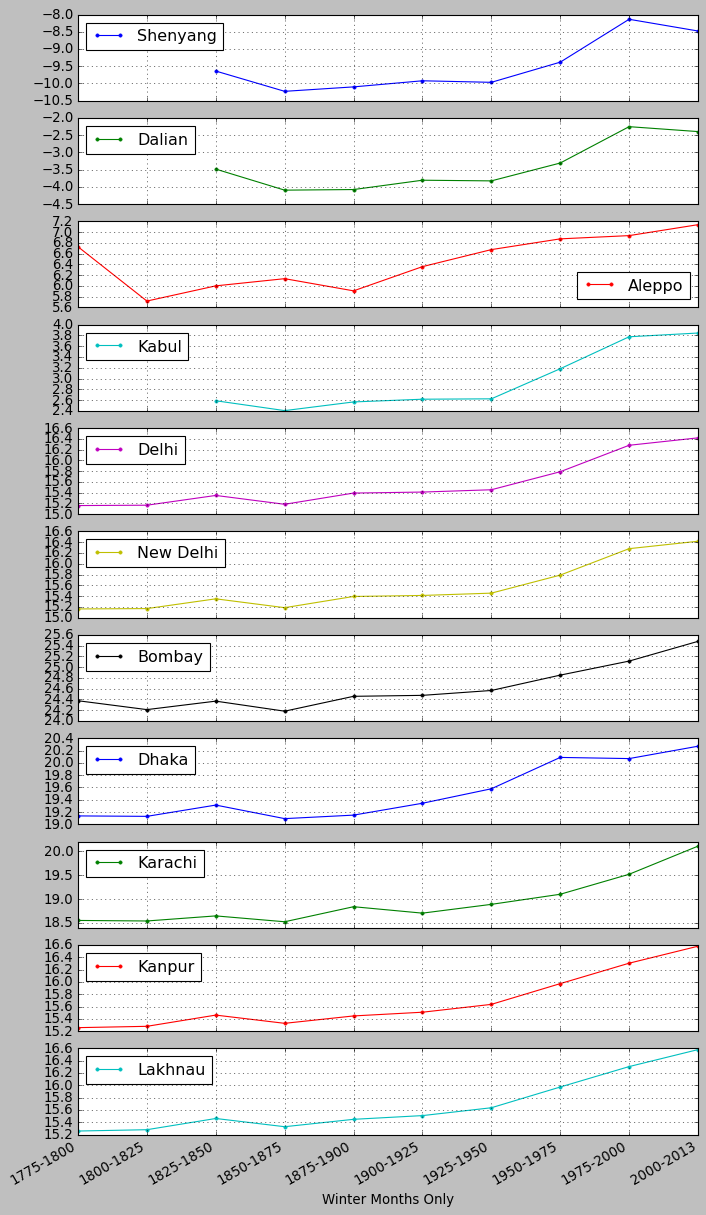

In [39]:
winter_only[last_ten_diff_decade].plot(subplots=True, figsize=(10,20), grid=True, xlabel='Winter Months Only', marker='.')
plt.show()

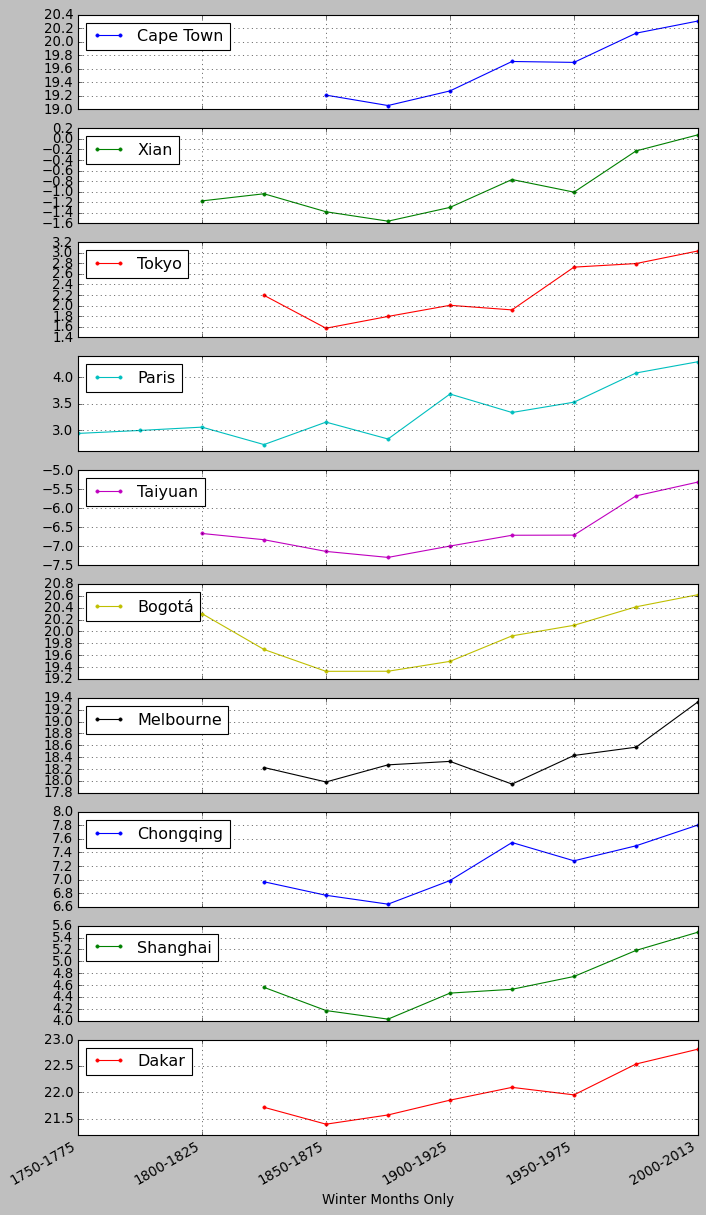

In [40]:
winter_only[med_ten_diff_decade].plot(subplots=True, figsize=(10,20), grid=True, xlabel='Winter Months Only', marker='.')
plt.show()

#### What about specific months?
#### It would be wise to use for each city the month with the lowest yearly deviation in order to see better the possible effect of climate change.
##### Let's find which month has the lowest yearly deviation for each city and plot the decade averages for that month.

In [41]:
lowest_std_month = dict(zip(
    (major_cities.groupby(['month', 'year', 'City'
    ]).mean()['AverageTemperature'].unstack(level=[2,0]).std().unstack(level=0).apply(np.argmin)+1).index, 
    
    major_cities.groupby([
    'month', 'year', 'City'
    ]).mean()['AverageTemperature'].unstack(level=[2,0]).std().unstack(level=0).apply(np.argmin)+1
))

lowest_std_month

{'Abidjan': 10,
 'Addis Abeba': 9,
 'Ahmadabad': 8,
 'Aleppo': 8,
 'Alexandria': 8,
 'Ankara': 6,
 'Baghdad': 7,
 'Bangalore': 8,
 'Bangkok': 7,
 'Belo Horizonte': 1,
 'Berlin': 9,
 'Bogotá': 7,
 'Bombay': 7,
 'Brasília': 1,
 'Cairo': 7,
 'Calcutta': 7,
 'Cali': 7,
 'Cape Town': 6,
 'Casablanca': 8,
 'Changchun': 7,
 'Chengdu': 7,
 'Chicago': 8,
 'Chongqing': 6,
 'Dakar': 9,
 'Dalian': 8,
 'Dar Es Salaam': 10,
 'Delhi': 8,
 'Dhaka': 7,
 'Durban': 6,
 'Faisalabad': 8,
 'Fortaleza': 10,
 'Gizeh': 7,
 'Guangzhou': 7,
 'Harare': 2,
 'Harbin': 7,
 'Ho Chi Minh City': 7,
 'Hyderabad': 8,
 'Ibadan': 10,
 'Istanbul': 6,
 'Izmir': 8,
 'Jaipur': 8,
 'Jakarta': 7,
 'Jiddah': 8,
 'Jinan': 9,
 'Kabul': 7,
 'Kano': 9,
 'Kanpur': 8,
 'Karachi': 6,
 'Kiev': 8,
 'Kinshasa': 10,
 'Lagos': 10,
 'Lahore': 8,
 'Lakhnau': 8,
 'Lima': 9,
 'London': 6,
 'Los Angeles': 7,
 'Luanda': 10,
 'Madras': 3,
 'Madrid': 8,
 'Manila': 7,
 'Mashhad': 7,
 'Melbourne': 7,
 'Mexico': 7,
 'Mogadishu': 10,
 'Montreal': 8,
 'M

In [42]:
values = []
for city in ten_cities:
    values.append(
            major_cities.groupby(['quadrant_century', 'month', 'City']).mean()['AverageTemperature'].xs(
                                                    lowest_std_month[city], level=1, drop_level=True).xs(city, level=1))

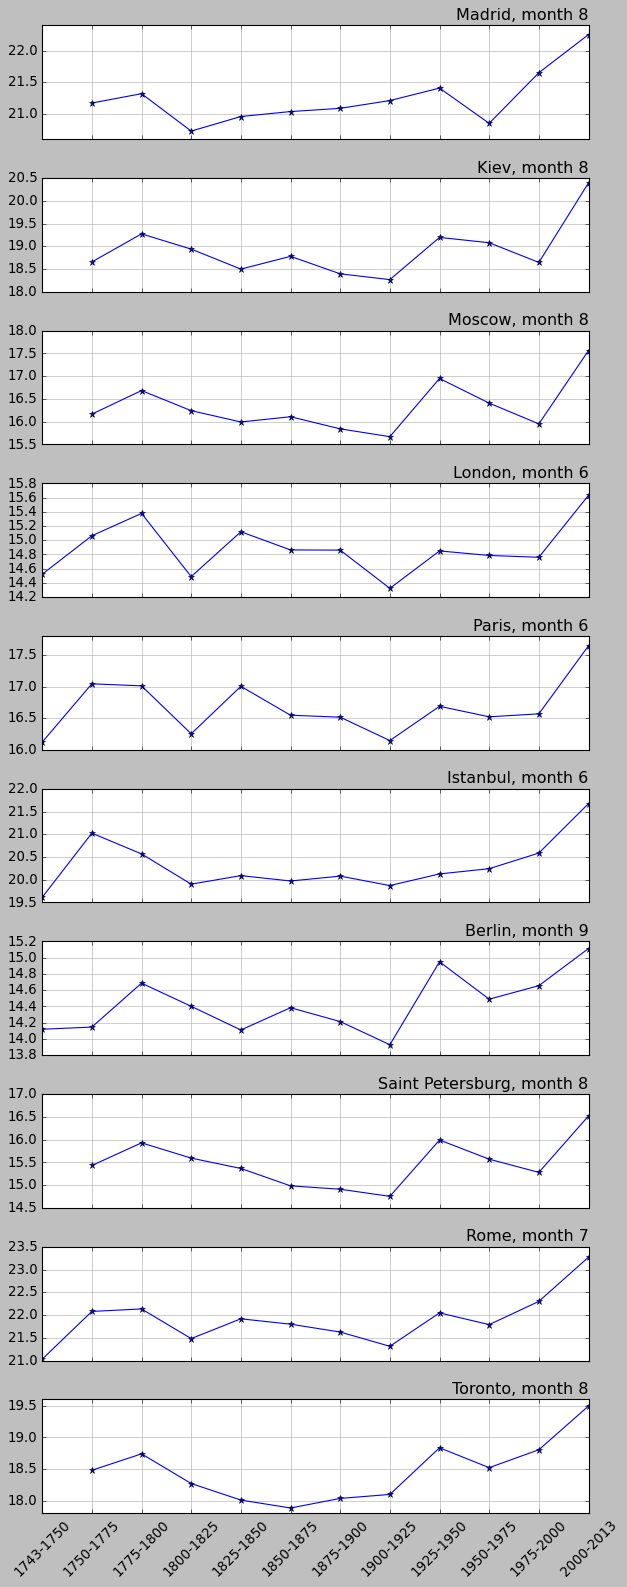

In [43]:
fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(8,20), sharex=True, tight_layout=True,)
for i in range(10):
    axs[i].plot(values[i], marker='*')
    axs[i].set_axisbelow(True)
    axs[i].yaxis.grid(color='darkgray', linestyle='-')
    axs[i].xaxis.grid(color='darkgray', linestyle='-')
    axs[i].set_title(ten_cities[i] + ', month ' + str(lowest_std_month[ten_cities[i]]), loc='right')

plt.xticks(rotation=45)
plt.show()

# 2. Working with Latitudes and Longitudes

### This time I'll use the dataset with all the cities.

#### First I create some chronological columnslike before.

In [44]:
all_cities = pd.read_csv('../input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCity.csv')

In [45]:
all_cities.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [46]:
all_cities['dt'] = all_cities['dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
all_cities['quadrant_century'] = all_cities['dt'].apply(lambda x: x.year//25)
all_cities['decade'] = all_cities['dt'].apply(lambda x: x.year//10)

#### Turn the coordinate values to positive annd negative based on North/South and East/West

In [47]:
all_cities['Latitude'] = all_cities['Latitude'].apply(lambda x: -float(x[:-1]) if x[-1] == 'S' else float(x[:-1]))
all_cities['Longitude'] = all_cities['Longitude'].apply(lambda x: -float(x[:-1]) if x[-1] == 'W' else float(x[:-1]))

In [48]:
all_cities['quadrant_century'] = all_cities['quadrant_century'].map(d_25_year)

In [49]:
all_cities.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,quadrant_century,decade
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05,10.33,1743-1750,174
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05,10.33,1743-1750,174
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05,10.33,1743-1750,174
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05,10.33,1743-1750,174
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05,10.33,1743-1750,174


#### Creating a DataFrame with all the unique cities and their coordinates

In [50]:
unique_cities = all_cities[['City', 'Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True)
unique_cities.head()

,City,Latitude,Longitude
0,Århus,57.05,10.33
1,Çorlu,40.99,27.69
2,Çorum,40.99,34.08
3,Öskemen,50.63,82.39
4,Ürümqi,44.20,87.20


**Next I check if there is any correlation between the difference in average temperatures of the 25-year periods starting in 1750 & 1850 and those of the period 2000-2013 **

In [51]:
diffs_1 = all_cities.loc[all_cities.quadrant_century.isin(
                                ['1750-1775', '2000-2013']
                                                )].groupby(
                                                        ['quadrant_century', 'City']
                                                                    ).mean()['AverageTemperature'].unstack(level=1).diff().iloc[1]
diffs_2 = all_cities.loc[all_cities.quadrant_century.isin(
                                ['1850-1875', '2000-2013']
                                                )].groupby(
                                                        ['quadrant_century', 'City']
                                                                    ).mean()['AverageTemperature'].unstack(level=1).diff().iloc[1]


diffs_and_coords = unique_cities.join(diffs_1, on='City').join(diffs_2, on='City', rsuffix='_2')
diffs_and_coords.columns = ['City', 'Latitude', 'Longitude', 'diff_between_1750-1775_and_2000-2013', 'diff_between_1850-1875_and_2000-2013']
diffs_and_coords.head()

,City,Latitude,Longitude,diff_between_1750-1775_and_2000-2013,diff_between_1850-1875_and_2000-2013
0,Århus,57.05,10.33,1.511140,1.443561
1,Çorlu,40.99,27.69,1.282982,1.336483
2,Çorum,40.99,34.08,1.068307,1.297740
3,Öskemen,50.63,82.39,NaN,1.690636
4,Ürümqi,44.20,87.20,NaN,1.690291


In [52]:
diffs_and_coords.corr()[['Latitude', 'Longitude']].iloc[2:]

,Latitude,Longitude
diff_between_1750-1775_and_2000-2013,-0.287565,-0.146031
diff_between_1850-1875_and_2000-2013,0.374464,0.164750


#### What these correlations show is that the first difference is larger the more southern the city and the more east from the prime meridian we go, while the second difference is larger the more northern the city and the more west from the prime meridian. The latitude correlations are stronger, however none of them is very large in absolute values.

#### Next: check correlations with fixed N/S Latitude or E/W Longitude

In [53]:
print('North hemisphere')
diffs_and_coords.loc[diffs_and_coords.Latitude > 0].corr()[['Latitude', 'Longitude']].iloc[2:]

North hemisphere


,Latitude,Longitude
diff_between_1750-1775_and_2000-2013,-0.268762,-0.162107
diff_between_1850-1875_and_2000-2013,0.451976,0.155716


In [54]:
print('South hemisphere')
diffs_and_coords.loc[diffs_and_coords.Latitude < 0].corr()[['Latitude', 'Longitude']].iloc[2:]
# Keep in mind that South-hemisphere cities have a lot of missing values in the earlier period

South hemisphere


,Latitude,Longitude
diff_between_1750-1775_and_2000-2013,-1.000000,1.000000
diff_between_1850-1875_and_2000-2013,0.193349,0.092509


In [55]:
print('East of prime meridian')
diffs_and_coords.loc[diffs_and_coords.Longitude > 0].corr()[['Latitude', 'Longitude']].iloc[2:]

East of prime meridian


,Latitude,Longitude
diff_between_1750-1775_and_2000-2013,-0.239341,0.390863
diff_between_1850-1875_and_2000-2013,0.501611,-0.204014


In [56]:
print('West of prime meridian')
diffs_and_coords.loc[diffs_and_coords.Longitude < 0].corr()[['Latitude', 'Longitude']].iloc[2:]

West of prime meridian


,Latitude,Longitude
diff_between_1750-1775_and_2000-2013,-0.297198,-0.23589
diff_between_1850-1875_and_2000-2013,-0.006978,0.23260


#### The stronger correlations appear in the North hemisphere and East of the prime meridian cities. Let's plot those.

In [57]:
plt.style.use('fivethirtyeight')

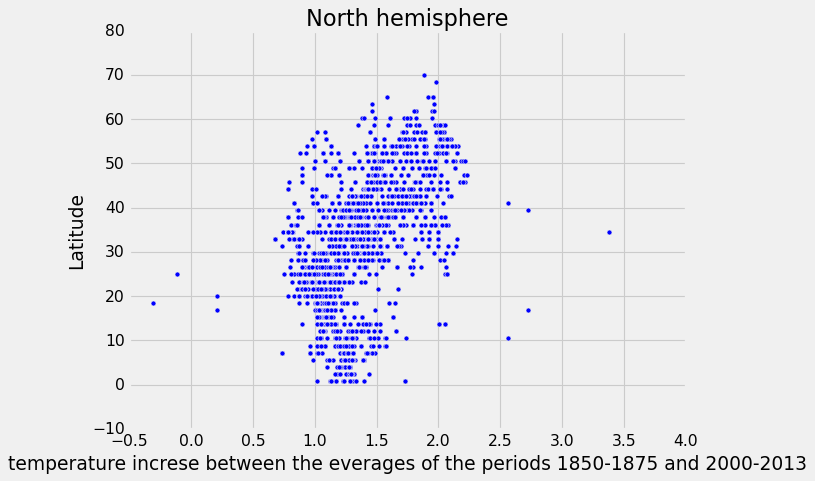

In [58]:
# We'll need to drop the outliers
plt.scatter(x=diffs_and_coords.loc[
                (diffs_and_coords.Latitude >0) & 
                (diffs_and_coords['diff_between_1850-1875_and_2000-2013'] < 6)
                                    ]['diff_between_1850-1875_and_2000-2013'],
            y=diffs_and_coords.loc[
                (diffs_and_coords.Latitude >0) & 
                (diffs_and_coords['diff_between_1850-1875_and_2000-2013'] < 6)
                                    ]['Latitude'])
plt.title('North hemisphere')
plt.xlabel('temperature increse between the everages of the periods 1850-1875 and 2000-2013')
plt.ylabel('Latitude')
plt.show()

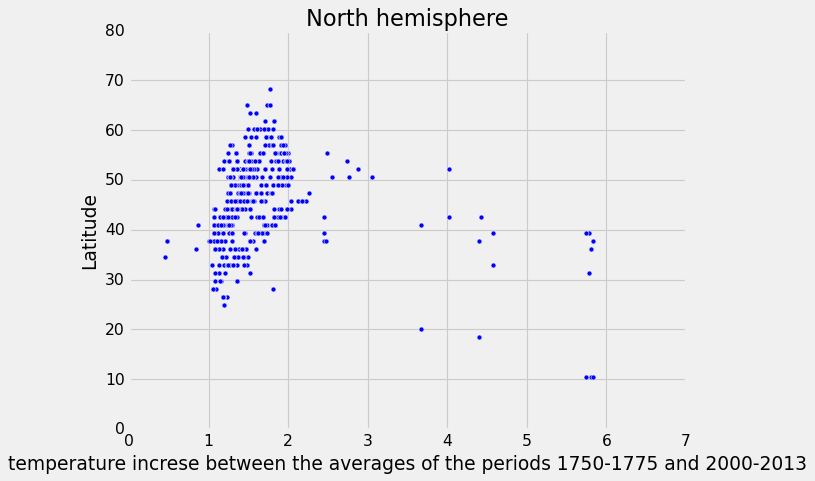

In [59]:
# We'll need to drop the outliers
plt.scatter(x=diffs_and_coords.loc[
                (diffs_and_coords.Latitude >0) & 
                (diffs_and_coords['diff_between_1750-1775_and_2000-2013'] < 6)
                                    ]['diff_between_1750-1775_and_2000-2013'],
            y=diffs_and_coords.loc[
                (diffs_and_coords.Latitude >0) & 
                (diffs_and_coords['diff_between_1750-1775_and_2000-2013'] < 6)
                                    ]['Latitude'])
plt.title('North hemisphere')
plt.xlabel('temperature increse between the averages of the periods 1750-1775 and 2000-2013')
plt.ylabel('Latitude')
plt.show()

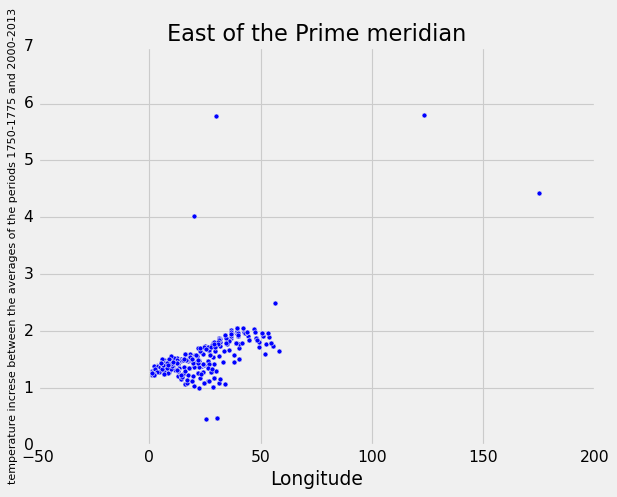

In [60]:
plt.scatter(y=diffs_and_coords.loc[
                (diffs_and_coords.Longitude >0) & 
                (diffs_and_coords['diff_between_1750-1775_and_2000-2013'] < 6)
                                    ]['diff_between_1750-1775_and_2000-2013'],
            x=diffs_and_coords.loc[
                (diffs_and_coords.Longitude >0) & 
                (diffs_and_coords['diff_between_1750-1775_and_2000-2013'] < 6)
                                    ]['Longitude'])
plt.title('East of the Prime meridian')
plt.ylabel('temperature increse between the averages of the periods 1750-1775 and 2000-2013', fontsize=10)
plt.xlabel('Longitude')
plt.show()

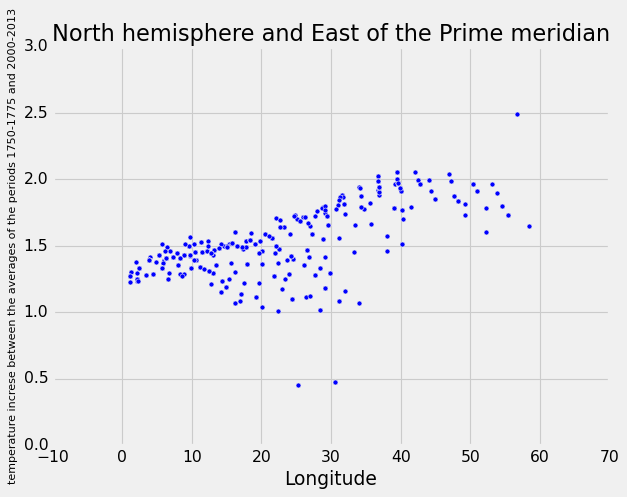

In [61]:
plt.scatter(y=diffs_and_coords.loc[
                (diffs_and_coords.Latitude >0) &
                (diffs_and_coords.Longitude >0) & 
                (diffs_and_coords['diff_between_1750-1775_and_2000-2013'] < 5)
                                    ]['diff_between_1750-1775_and_2000-2013'],
            x=diffs_and_coords.loc[
                (diffs_and_coords.Latitude >0) &
                (diffs_and_coords.Longitude >0) & 
                (diffs_and_coords['diff_between_1750-1775_and_2000-2013'] < 5)
                                    ]['Longitude'])
plt.title('North hemisphere and East of the Prime meridian')
plt.ylabel('temperature increse between the averages of the periods 1750-1775 and 2000-2013', fontsize=10)
plt.xlabel('Longitude')
plt.show()

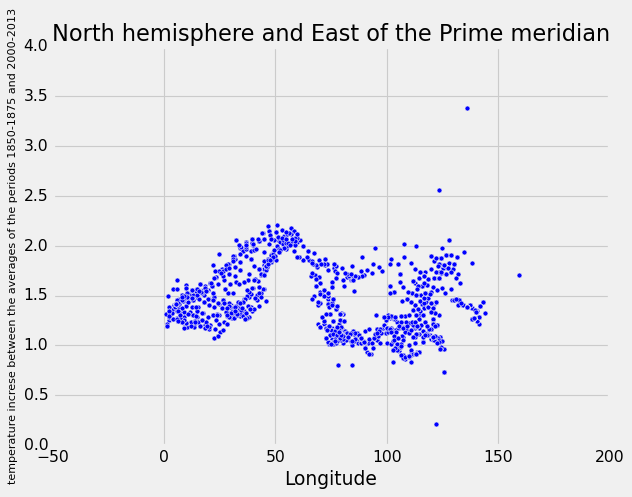

In [62]:
plt.scatter(y=diffs_and_coords.loc[
                (diffs_and_coords.Latitude >0) &
                (diffs_and_coords.Longitude >0) & 
                (diffs_and_coords['diff_between_1850-1875_and_2000-2013'] < 5)
                                    ]['diff_between_1850-1875_and_2000-2013'],
            x=diffs_and_coords.loc[
                (diffs_and_coords.Latitude >0) &
                (diffs_and_coords.Longitude >0) & 
                (diffs_and_coords['diff_between_1850-1875_and_2000-2013'] < 5)
                                    ]['Longitude'])
plt.title('North hemisphere and East of the Prime meridian')
plt.ylabel('temperature increse between the averages of the periods 1850-1875 and 2000-2013', fontsize=10)
plt.xlabel('Longitude')
plt.show()

### There seem to be positive correlation for longitudes 0-60, negative correlation for 60-100, and then positive again for further east.

### Finally, let's plot the whole map.

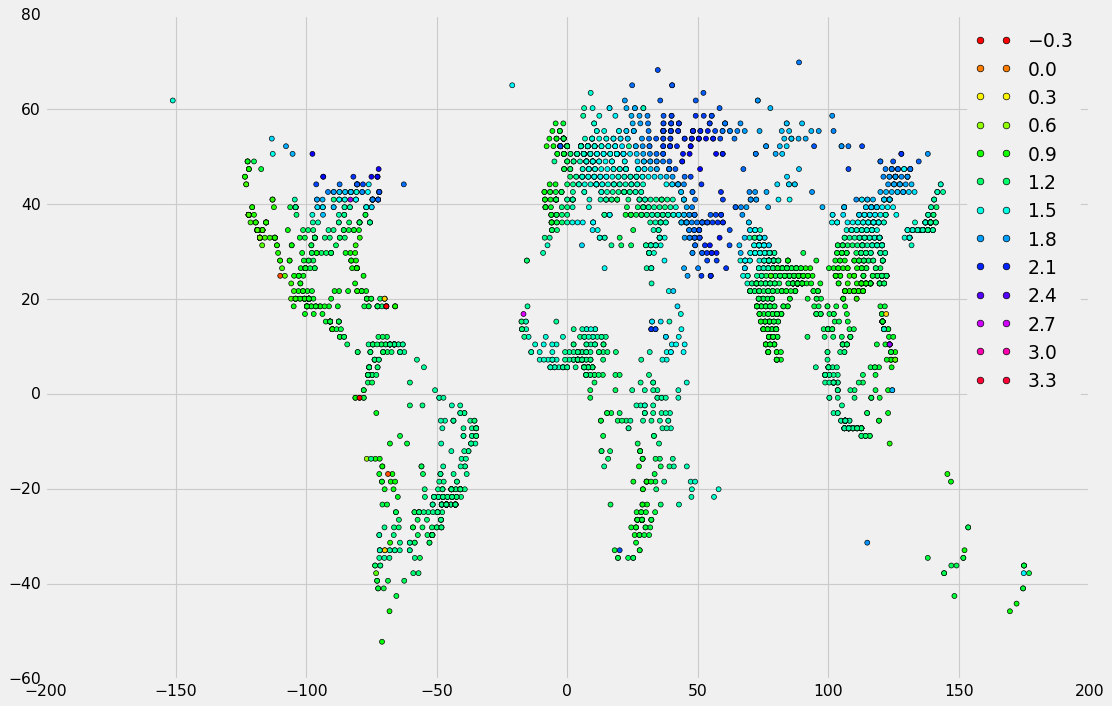

In [63]:
x = diffs_and_coords.loc[diffs_and_coords['diff_between_1850-1875_and_2000-2013']<5]['Longitude']
y = diffs_and_coords.loc[diffs_and_coords['diff_between_1850-1875_and_2000-2013']<5]['Latitude']
c = diffs_and_coords.loc[diffs_and_coords['diff_between_1850-1875_and_2000-2013']<5]['diff_between_1850-1875_and_2000-2013']

fig, ax = plt.subplots(figsize=(15,10))

scatter = ax.scatter(x,y,c=c, cmap='hsv', alpha=1, lw=0.6, ec='black')

handles, labels = scatter.legend_elements(prop = 'colors')
ax.legend(handles, labels)

plt.show()

### It seems that certain regions like Central Asia, Siberia and Northeast US we affected more .